In [88]:
import cv2 
import pytesseract
import numpy as np
from matplotlib import pyplot as plt
import re
from pdf2image import convert_from_path

In [90]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 2)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


#opening - erosion followed by dilation
def closing(image):
    kernel = np.ones((7,7),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 50, 50)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [91]:
image = cv2.imread('images/page2.jpg')
img =get_grayscale(image)

In [93]:
result = thresholding(img)
result = dilate(result)
result = erode(result)
result = remove_noise(result)
result = closing(result)
result = erode(result)
result = erode(result)
result = erode(result)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=result, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image
image_copy = img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

array([[  0,   0,   0, ..., 254, 254, 253],
       [  0,   0,   0, ..., 255, 255, 253],
       [  0,   0, 103, ...,  70, 225, 252],
       ...,
       [  0,   0, 111, ..., 119,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

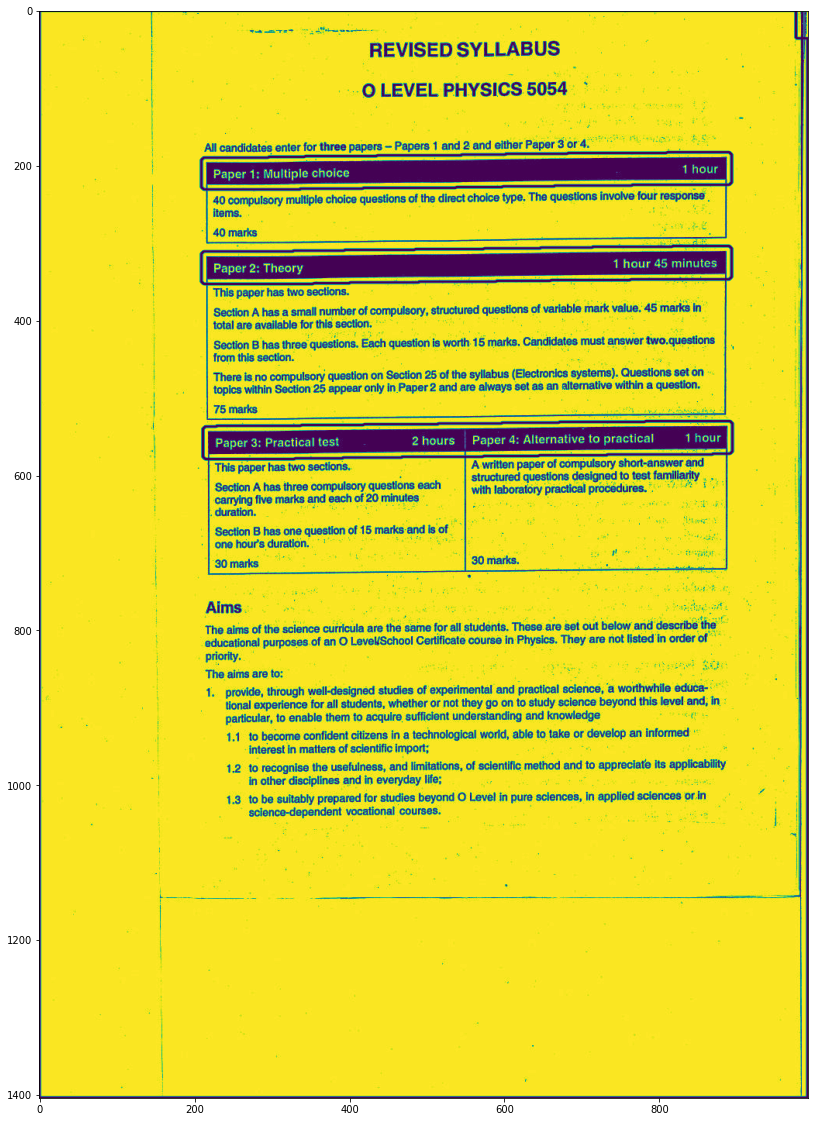

In [100]:
plt.figure(figsize = (50,20))
plt.imshow(image_copy)

In [7]:
mask = np.zeros(result.shape,np.uint8)
cv2.drawContours(mask,contours,0,255,-1)
pixelpoints = np.transpose(np.nonzero(mask))

In [8]:
end = pixelpoints.shape[0]
for i in range(0,end):
    row,col=pixelpoints[i]
    if(img[row][col]==0):
        img[row][col]==255
    else:
        img[row][col]==0

In [109]:
img_copy= img
x,y = img_copy.shape

for i in range(0,x):
    for j in range(0,y):
        temp=cv2.pointPolygonTest(contours[1], (j,i),True)
        temp2=cv2.pointPolygonTest(contours[2], (j,i),True)
        temp3=cv2.pointPolygonTest(contours[3], (j,i),True)
        if(temp>0 or temp2>0 or temp3>0):
            if(img_copy[i][j]>100):
                img_copy[i][j]=0
            else:
                img_copy[i][j]=255

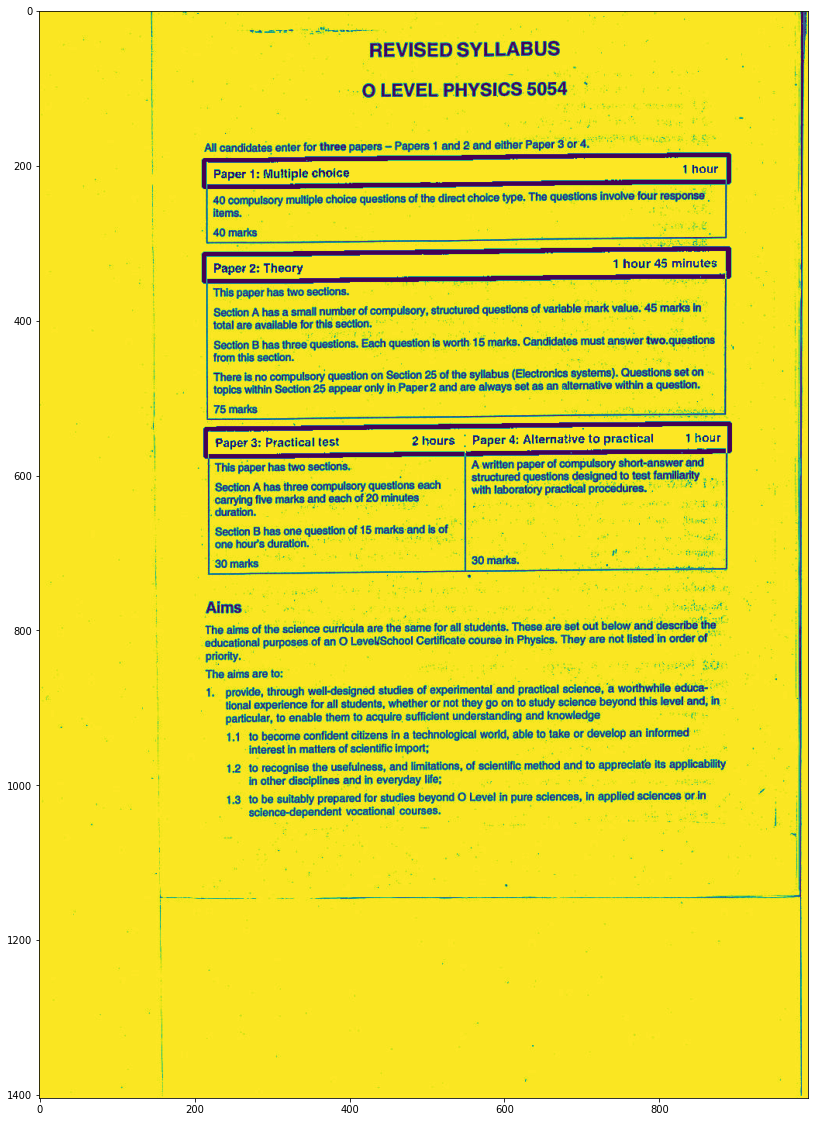

In [110]:
plt.figure(figsize = (50,20))
plt.imshow(img_copy)

In [111]:
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img_copy, config=custom_config)

"i REVISED SYLLABUS\n|\nO LEVEL PHYSICS 5054 ~\nAll candidates enter for three papers — Papers 1 and 2 and either Paper 3 or 4. s\nPaper 1: Muttiple choice 1 hour\n40 compulsory multiple choice questions of the direct choice type. The questions involve four response\nitems.\n40 marks\nPaper 2: Theory 1 hour 45 minutes\nThis paper has two sections.\nSection A has a small number of compulsory, structured questions of variable mark value. 45 marks in\ntotal are available for this section.\nSection B has three questions. Each question is worth 16 marks. Candidates must answer two.questions |\nfrom this section. ‘\nThere is no compulsory question on Section 25 of the syllabus (Electronics systems). Questions set on\ni topics within Section 25 appear only in Paper 2 and are always set as an alternative within a question.\n| 75 marks\nPaper 3: Practical test 2hours ' Paper 4: Alternative to practical 1 hour\n|\nThis paper has two sections. ‘A wmritten paper of compulsory short-answer and |\ns